### 赛题理解：以新闻APP中的新闻推荐为背景， 目的是要求我们根据用户历史浏览点击新闻文章的数据信息预测用户未来的点击行为， 即用户的最后一次点击的新闻文章
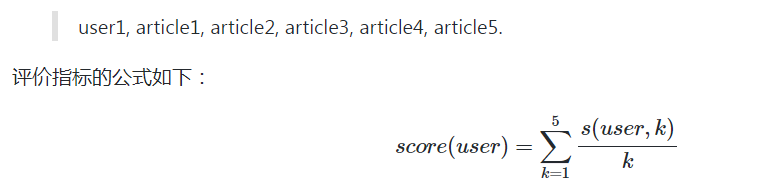

### 问题转换：预测某个用户最后一次对于某一篇文章会进行点击的概率

# 导包

In [1]:
# import packages
# import packages
import time, math, os
from tqdm import tqdm  # 从 tqdm 库中导入 tqdm 类，用于在循环中显示进度条，方便用户了解程序运行进度
import gc
import pickle
import random
from datetime import datetime
from operator import itemgetter
import numpy as np
import pandas as pd
import warnings
from collections import defaultdict
import collections
warnings.filterwarnings('ignore') # 忽略所有警告信息，避免警告信息干扰程序的正常输出


In [2]:
# 数据文件存储路径，指定为 D:\Code\jupyter Notebooks\alitc_rec 
data_path = './data_raw/'
save_path = './tmp_results/'


### df节省内存函数


In [3]:
# 节约内存的一个标配函数
#一个包含 100 万个整数的列，原本使用 np.int64 存储，占用内存为 1000000×8字节（即 8MB）；若经过判断后将其转换为 np.int8 存储，占用内存就变为 1000000×1字节（即 1MB），内存占用减少了 7MB。
# 节约内存的一个标配函数
def reduce_mem(df):
    starttime = time.time()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if pd.isnull(c_min) or pd.isnull(c_max):
                continue
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('-- Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction),time spend:{:2.2f} min'.format(end_mem,
                                                                                                           100*(start_mem-end_mem)/start_mem,
                                                                                                           (time.time()-starttime)/60))
    return df


### 读取采样或全量数据

In [4]:
# debug模式：从训练集中划出一部分数据来调试代码
def get_all_click_sample(data_path, sample_nums=10000):
    """
        训练集中采样一部分数据调试
        data_path: 原数据的存储路径
        sample_nums: 采样数目（这里由于机器的内存限制，可以采样用户做）
    """
    all_click = pd.read_csv(data_path + 'train_click_log.csv')
    all_user_ids = all_click.user_id.unique()

    sample_user_ids = np.random.choice(all_user_ids, size=sample_nums, replace=False) 
    all_click = all_click[all_click['user_id'].isin(sample_user_ids)]
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

# 读取点击数据，这里分成线上和线下，如果是为了获取线上提交结果应该讲测试集中的点击数据合并到总的数据中
# 如果是为了线下验证模型的有效性或者特征的有效性，可以只使用训练集
def get_all_click_df(data_path='./data_raw/', offline=True):
    if offline:
        all_click = pd.read_csv(data_path + 'train_click_log.csv')
    else:
        trn_click = pd.read_csv(data_path + 'train_click_log.csv')
        tst_click = pd.read_csv(data_path + 'testA_click_log.csv')

        all_click = pd.concat([trn_click, tst_click], ignore_index=True)
    
    all_click = all_click.drop_duplicates((['user_id', 'click_article_id', 'click_timestamp']))
    return all_click

In [5]:
# 全量训练集
all_click_df = get_all_click_df(offline=False)


### 获取 用户 - 文章 - 点击时间字典

In [6]:
# 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
def get_user_item_time(click_df):
    # 按照点击时间进行排序
    click_df = click_df.sort_values('click_timestamp')

    def make_item_time_pair(df):
        return list(zip(df['click_article_id'], df['click_timestamp']))

    # 明确使用列表选取列
    user_item_time_df = click_df.groupby('user_id')[['click_article_id', 'click_timestamp']].apply(lambda x: make_item_time_pair(x))\
                                                            .reset_index().rename(columns={0: 'item_time_list'})
    user_item_time_dict = dict(zip(user_item_time_df['user_id'], user_item_time_df['item_time_list']))

    return user_item_time_dict

### 获取点击最多的topk个文章

In [7]:
# 获取近期点击最多的文章
def get_item_topk_click(click_df, k):
    topk_click = click_df['click_article_id'].value_counts().index[:k]
    return topk_click

### itemcf的物品相似度计算

In [8]:
def itemcf_sim(df):
    """
        文章与文章之间的相似性矩阵计算
        :param df: 数据表
        :item_created_time_dict:  文章创建时间的字典
        return : 文章与文章的相似性矩阵
        思路: 基于物品的协同过滤(详细请参考上一期推荐系统基础的组队学习)， 在多路召回部分会加上关联规则的召回策略
    """
    
    user_item_time_dict = get_user_item_time(df)
    
    # 计算物品相似度
    i2i_sim = {}
    item_cnt = defaultdict(int)
    for user, item_time_list in tqdm(user_item_time_dict.items()):
        # 在基于商品的协同过滤优化的时候可以考虑时间因素
        for i, i_click_time in item_time_list:
            item_cnt[i] += 1
            i2i_sim.setdefault(i, {})
            for j, j_click_time in item_time_list:
                if(i == j):
                    continue
                i2i_sim[i].setdefault(j, 0)
                
                i2i_sim[i][j] += 1 / math.log(len(item_time_list) + 1)
                
    i2i_sim_ = i2i_sim.copy()
    for i, related_items in i2i_sim.items():
        for j, wij in related_items.items():
            i2i_sim_[i][j] = wij / math.sqrt(item_cnt[i] * item_cnt[j])
    
    # 将得到的相似性矩阵保存到本地
    pickle.dump(i2i_sim_, open(save_path + 'itemcf_i2i_sim.pkl', 'wb'))
    
    return i2i_sim_


In [9]:
i2i_sim = itemcf_sim(all_click_df)

100%|████████████████████████████████████████████████████████████████████████| 250000/250000 [00:32<00:00, 7792.15it/s]


### itemcf 的文章推荐

In [10]:
# 基于商品的召回i2i
def item_based_recommend(user_id, user_item_time_dict, i2i_sim, sim_item_topk, recall_item_num, item_topk_click):
    """
        基于文章协同过滤的召回
        :param user_id: 用户id
        :param user_item_time_dict: 字典, 根据点击时间获取用户的点击文章序列   {user1: [(item1, time1), (item2, time2)..]...}
        :param i2i_sim: 字典，文章相似性矩阵
        :param sim_item_topk: 整数， 选择与当前文章最相似的前k篇文章
        :param recall_item_num: 整数， 最后的召回文章数量
        :param item_topk_click: 列表，点击次数最多的文章列表，用户召回补全        
        return: 召回的文章列表 {item1:score1, item2: score2...}
        注意: 基于物品的协同过滤(详细请参考上一期推荐系统基础的组队学习)， 在多路召回部分会加上关联规则的召回策略
    """
    
    # 获取用户历史交互的文章
    user_hist_items = user_item_time_dict[user_id]
    user_hist_items_ = {user_id for user_id, _ in user_hist_items}
    
    item_rank = {}
    for loc, (i, click_time) in enumerate(user_hist_items):
        for j, wij in sorted(i2i_sim[i].items(), key=lambda x: x[1], reverse=True)[:sim_item_topk]:
            if j in user_hist_items_:
                continue
                
            item_rank.setdefault(j, 0)
            item_rank[j] +=  wij
    
    # 不足10个，用热门商品补全
    if len(item_rank) < recall_item_num:
        for i, item in enumerate(item_topk_click):
            if item in item_rank: # 填充的item应该不在原来的列表中
                continue
            item_rank[item] = - i - 100 # 随便给个负数就行
            if len(item_rank) == recall_item_num:
                break
    
    item_rank = sorted(item_rank.items(), key=lambda x: x[1], reverse=True)[:recall_item_num]
        
    return item_rank

### 给每个用户根据物品的协同过滤推荐文章

In [11]:
# 定义
user_recall_items_dict = collections.defaultdict(dict)

# 获取 用户 - 文章 - 点击时间的字典
user_item_time_dict = get_user_item_time(all_click_df)

# 去取文章相似度
i2i_sim = pickle.load(open(save_path + 'itemcf_i2i_sim.pkl', 'rb'))

# 相似文章的数量
sim_item_topk = 10

# 召回文章数量
recall_item_num = 10

# 用户热度补全
item_topk_click = get_item_topk_click(all_click_df, k=50)

for user in tqdm(all_click_df['user_id'].unique()):
    user_recall_items_dict[user] = item_based_recommend(user, user_item_time_dict, i2i_sim, 
                                                        sim_item_topk, recall_item_num, item_topk_click)

100%|█████████████████████████████████████████████████████████████████████████| 250000/250000 [32:52<00:00, 126.72it/s]


### 召回字典转换成df

In [12]:
# 将字典的形式转换成df
user_item_score_list = []

for user, items in tqdm(user_recall_items_dict.items()):
    for item, score in items:
        user_item_score_list.append([user, item, score])

recall_df = pd.DataFrame(user_item_score_list, columns=['user_id', 'click_article_id', 'pred_score'])

100%|███████████████████████████████████████████████████████████████████████| 250000/250000 [00:04<00:00, 52655.79it/s]


### 生成提交文件

In [15]:
# 生成提交文件
def submit(recall_df, topk=5, model_name=None):
    recall_df = recall_df.sort_values(by=['user_id', 'pred_score'])
    recall_df['rank'] = recall_df.groupby(['user_id'])['pred_score'].rank(ascending=False, method='first')
    
    # 判断是不是每个用户都有5篇文章及以上
    tmp = recall_df.groupby('user_id').apply(lambda x: x['rank'].max())
    assert tmp.min() >= topk
    
    del recall_df['pred_score']
    submit = recall_df[recall_df['rank'] <= topk].set_index(['user_id', 'rank']).unstack(-1).reset_index()
    
    submit.columns = [int(col) if isinstance(col, int) else col for col in submit.columns.droplevel(0)]
    # 按照提交格式定义列名
    submit = submit.rename(columns={'': 'user_id', 1: 'article_1', 2: 'article_2', 
                                                  3: 'article_3', 4: 'article_4', 5: 'article_5'})
    
    save_name = save_path + model_name + '_' + datetime.today().strftime('%m-%d') + '.csv'
    submit.to_csv(save_name, index=False, header=True)


In [16]:
# 获取测试集
tst_click = pd.read_csv(data_path + 'testA_click_log.csv')
tst_users = tst_click['user_id'].unique()

# 从所有的召回数据中将测试集中的用户选出来
tst_recall = recall_df[recall_df['user_id'].isin(tst_users)]

# 生成提交文件
submit(tst_recall, topk=5, model_name='itemcf_baseline')
